In [1]:
import functools
from functools import partial

from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2

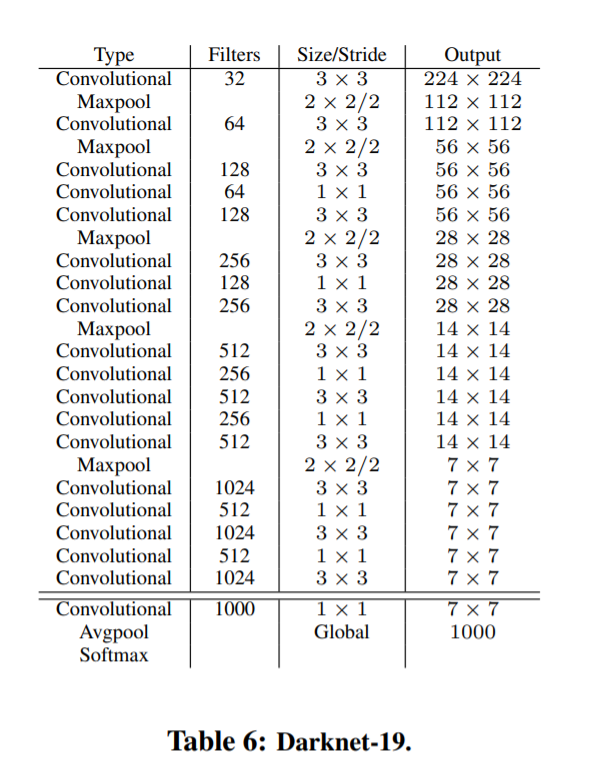

In [2]:
_DarknetConv2D = partial(Conv2D, padding='same') # Trình bao bọc 1 phần Convolution2D với đối số mặc định

In [4]:
@functools.wraps(Conv2D) # functools là một standard Python module cho các hàm bậc cao hơn (các hàm hoạt động trên hoặc trả về các hàm khác). wraps () là một decorator được áp dụng cho wrapper function của một decorator. Nó cập nhật wrapper function để trông giống như wrapped function bằng cách coping attributes như __name__, __doc__ (docstring), v.v.
def DarknetConv2D(*args, **kwargs):
    """Wrapper to set Darknet weight regularizer for Convolution2D."""
    darknet_conv_kwargs = {'kernel_regularizer': l2(5e-4)}
    darknet_conv_kwargs.update(kwargs)
    return _DarknetConv2D(*args, **darknet_conv_kwargs)


In [5]:
def DarknetConv2D_BN_Leaky(*args, **kwargs):
    """Darknet Convolution2D followed by BatchNormalization and LeakyReLU."""
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        DarknetConv2D(*args, **no_bias_kwargs),
        BatchNormalization(),
        LeakyReLU(alpha=0.1))

In [6]:
def bottleneck_block(outer_filters, bottleneck_filters):
    """Bottleneck block of 3x3, 1x1, 3x3 convolutions."""
    return compose(
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)),
        DarknetConv2D_BN_Leaky(bottleneck_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)))

In [7]:
def bottleneck_x2_block(outer_filters, bottleneck_filters):
    """Bottleneck block of 3x3, 1x1, 3x3, 1x1, 3x3 convolutions."""
    return compose(
        bottleneck_block(outer_filters, bottleneck_filters),
        DarknetConv2D_BN_Leaky(bottleneck_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)))

In [8]:
def darknet_body():
    """Generate first 18 conv layers of Darknet-19."""
    return compose(
        DarknetConv2D_BN_Leaky(32, (3, 3)),
        MaxPooling2D(),
        DarknetConv2D_BN_Leaky(64, (3, 3)),
        MaxPooling2D(),
        bottleneck_block(128, 64),
        MaxPooling2D(),
        bottleneck_block(256, 128),
        MaxPooling2D(),
        bottleneck_x2_block(512, 256),
        MaxPooling2D(),
        bottleneck_x2_block(1024, 512))

In [9]:
def darknet19(inputs):
    """Generate Darknet-19 model for Imagenet classification."""
    body = darknet_body()(inputs)
    logits = DarknetConv2D(1000, (1, 1), activation='softmax')(body)
    return Model(inputs, logits)